In [1]:
import sys
sys.path.append("/kaggle/input/yolov8/ultralytics-main")
# sys.path.append("/kaggle/input/ensemble-boxes")
# sys.path.append("/kaggle/input/ensemble-boxes/Weighted-Boxes-Fusion-master/ensemble_boxes")

In [2]:
import albumentations as A

import warnings

import shutil
import os
import torch
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
from glob import glob
import gc
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image as show_image

import ultralytics
from ultralytics import YOLO
from ultralytics import models
from ultralytics.yolo.utils.ops import scale_boxes, scale_coords, scale_image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.yolo.v8.segment import predict, SegmentationPredictor

import torch

ultralytics.checks()

Ultralytics YOLOv8.0.120 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4958.8/8062.4 GB disk)


In [3]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [4]:
from skimage.morphology import binary_dilation

def dilate_mask(mask, n_iter=1):
    for _ in range(n_iter):
        mask = binary_dilation(mask)
    return mask

In [5]:
%%writefile ensemble_boxes_nms.py
# coding: utf-8

import warnings
import numpy as np
from numba import jit


def prepare_boxes(boxes, scores):
    result_boxes = boxes.copy()

    cond = (result_boxes < 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates < 0'.format(cond_sum))
        result_boxes[cond] = 0

    cond = (result_boxes > 1)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates > 1. Check that your boxes were normalized at [0, 1]'.format(cond_sum))
        result_boxes[cond] = 1

    boxes1 = result_boxes.copy()
    result_boxes[:, 0] = np.min(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 2] = np.max(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 1] = np.min(boxes1[:, [1, 3]], axis=1)
    result_boxes[:, 3] = np.max(boxes1[:, [1, 3]], axis=1)

    area = (result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1])
    cond = (area == 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Removed {} boxes with zero area!'.format(cond_sum))
        result_boxes = result_boxes[area > 0]
        scores = scores[area > 0]

    return result_boxes, scores



def cpu_soft_nms_float(dets, sc, Nt, sigma, thresh, method):
    """
    Based on: https://github.com/DocF/Soft-NMS/blob/master/soft_nms.py
    It's different from original soft-NMS because we have float coordinates on range [0; 1]

    :param dets:   boxes format [x1, y1, x2, y2]
    :param sc:     scores for boxes
    :param Nt:     required iou 
    :param sigma:  
    :param thresh: 
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :return: index of boxes to keep
    """

    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)

    # the order of boxes coordinate is [y1, x1, y2, x2]
    y1 = dets[:, 1]
    x1 = dets[:, 0]
    y2 = dets[:, 3]
    x2 = dets[:, 2]
    scores = sc
    areas = (x2 - x1) * (y2 - y1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy()
        pos = i + 1

        #
        if i != N - 1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 1], dets[pos:, 1])
        yy1 = np.maximum(dets[i, 0], dets[pos:, 0])
        xx2 = np.minimum(dets[i, 3], dets[pos:, 3])
        yy2 = np.minimum(dets[i, 2], dets[pos:, 2])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = 0

        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    keep = inds.astype(int)
    return keep


@jit(nopython=True)
def nms_float_fast(dets, scores, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


def nms_method(boxes, scores, method=3, iou_thr=0.5, sigma=0.5, thresh=0.001, weights=None):
    """
    :param boxes: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1] 
    :param scores: list of scores for each model 
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :param iou_thr: IoU value for boxes to be a match 
    :param sigma: Sigma value for SoftNMS
    :param thresh: threshold for boxes to keep (important for SoftNMS)
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    """

    # If weights are specified
    if weights is not None:
        if len(boxes) != len(weights):
            print('Incorrect number of weights: {}. Must be: {}. Skip it'.format(len(weights), len(boxes)))
        else:
            weights = np.array(weights)
            for i in range(len(weights)):
                scores[i] = (np.array(scores[i]) * weights[i]) / weights.sum()

    # Do the checks and skip empty predictions
    filtered_boxes = []
    filtered_scores = []
    for i in range(len(boxes)):
        if len(boxes[i]) != len(scores[i]):
            print('Check length of boxes and scores: {} {} at position: {}. Boxes are skipped!'.format(len(boxes[i]), len(scores[i]), i))
            continue
        if len(boxes[i]) == 0:
            # print('Empty boxes!')
            continue
        filtered_boxes.append(boxes[i])
        filtered_scores.append(scores[i])
    
    
    # We concatenate everything
    boxes = np.concatenate(filtered_boxes)
    scores = np.concatenate(filtered_scores)
    

    # Fix coordinates and removed zero area boxes
    boxes, scores = prepare_boxes(boxes, scores)

    if method != 3:
        keep = cpu_soft_nms_float(boxes.copy(), scores.copy(), Nt=iou_thr, sigma=sigma, thresh=thresh, method=method)
    else:
        # Use faster function
        keep = nms_float_fast(boxes, scores, thresh=iou_thr)

    final_boxes = boxes[keep]
    final_scores = scores[keep]

    return final_boxes, final_scores


def nms(boxes, scores, iou_thr=0.5, weights=None):
    """
    Short call for standard NMS 
    
    :param boxes: 
    :param scores: 
    :param labels: 
    :param iou_thr: 
    :param weights: 
    :return: 
    """
    return nms_method(boxes, scores, method=3, iou_thr=iou_thr, weights=weights)


def soft_nms(boxes, scores, method=2, iou_thr=0.5, sigma=0.5, thresh=0.001, weights=None):
    """
    Short call for Soft-NMS
     
    :param boxes: 
    :param scores: 
    :param labels: 
    :param method: 
    :param iou_thr: 
    :param sigma: 
    :param thresh: 
    :param weights: 
    :return: 
    """
    return nms_method(boxes, scores, method=method, iou_thr=iou_thr, sigma=sigma, thresh=thresh, weights=weights)

Writing ensemble_boxes_nms.py


In [6]:
from ensemble_boxes_nms import nms

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
import os
HOME = os.getcwd()
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install
!pip install . --no-index --find-links /kaggle/working/packages/
os.chdir("/kaggle/working")

import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
from PIL import Image
import cv2
import pandas as pd
import os
from itertools import groupby
from skimage.measure import label, regionprops

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
cre

In [9]:
from dataclasses import dataclass

@dataclass
class CFG:
    dilation_n_iter: int = 1
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.7
    iou_nms_tta: float = 0.7   
    author: str = 'tg @ai_minds'
    transforms = [None]
#     transforms = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]
    models = [
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold0.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold1.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold2.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold3.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold4.pt',
        
    ]

    def __repr__(self):
        return f"CFG({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

In [10]:
def predict(image, models, transforms=[None], imgsz=512, conf=0.01, iou_nms=0.5, retina_masks=True, iou_nms_tta=0.7):
    masks, scores, boxes = [], [], []
    
    og_img = np.array(image.copy()).astype(np.uint8)[...,::-1]
    h, w = og_img.shape[:2]
    
    for model in models:
        for transform in transforms:
            if transform is not None:
                img = transform(image=og_img)['image']
            else:
                img = og_img.copy()
            
            pred = model.predict(img, imgsz=imgsz, conf=conf, iou=iou_nms, retina_masks=retina_masks)[0]
            
            if pred.masks is None:
                continue
            
            pred_masks = pred.masks.data[pred.boxes.cls == 0].detach().cpu().numpy()
            
            if len(pred_masks) == 0:
                continue
            pred_confs = pred.boxes.conf[pred.boxes.cls == 0].detach().cpu().numpy()
            pred_boxes = pred.boxes.data[pred.boxes.cls == 0].detach().cpu().numpy()
            
            pred_boxes = A.core.bbox_utils.normalize_bboxes(pred_boxes, h, w)
            
            if transform is not None:
                # optim here
                pred_boxes = transform(image=img, bboxes=pred_boxes)['bboxes']
                pred_masks = transform(image=img, masks=pred_masks)['masks']
            
            boxes.append(np.array(pred_boxes))
            scores.append(np.array(pred_confs))
            masks.append(pred_masks)
            del pred, pred_boxes, pred_masks, img
    del og_img
    

    if len(boxes) == 0:
        return np.zeros((1, h, w)), [0]
    
    labels = [np.ones(len(b)) for b in boxes]
    boxes = np.concatenate(boxes)
    scores = np.concatenate(scores)
    masks = np.concatenate(masks)
    
    nms_boxes, nms_scores = nms(
                                [boxes],
                                [scores],
                                iou_thr=iou_nms_tta
                               )

    nms_masks = []
    scores_list = scores.tolist()
    for s in nms_scores:
        nms_masks.append(masks[scores_list.index(s)])
    nms_masks = np.stack(nms_masks).astype(bool)
    nms_scores = np.array(nms_scores)
    
    return nms_masks, nms_scores

In [11]:
models = [
    YOLO(p) for p in CFG.models
]

In [12]:
all_rows = []
results_csv = pd.DataFrame([], columns=["id","height","width","prediction_string"])
results_csv.set_index("id")

for dirname, _, filenames in os.walk('/kaggle/input/hubmap-hacking-the-human-vasculature/test'):
    for filename in filenames:
        
        image = Image.open(os.path.join(dirname, filename))
        width, height = image.size
        
        row = dict()
        row["id"] = filename[:-4]
        row["height"] = height
        row["width"] = width
        row["prediction_string"] = ""
        
        masks, scores = predict(image=image,
                                models=models,
                                transforms=CFG.transforms,
                                imgsz=CFG.imgsz,
                                conf=CFG.conf,
                                iou_nms=CFG.iou_nms,
                                retina_masks=CFG.retina_masks,
                               )
        
        for i, (mask, score) in enumerate(sorted(zip(masks, scores), key=lambda x: x[1], reverse=True)):
            mask = dilate_mask(mask, n_iter=CFG.dilation_n_iter)
            
            coded_len = encode_binary_mask(mask.astype(bool)).decode('utf-8')
            row["prediction_string"] += '0 ' + str(score)+' '+ coded_len+' '
        
        new_row = pd.DataFrame(row, index=[0])
        results_csv = pd.concat([new_row, results_csv.loc[:]]).reset_index(drop=True)

results_csv.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
!cat submission.csv

id,height,width,prediction_string
72e40acccadf,512,512,0 0.8953215 eNqLywgwtUm2N/I39DMEYiANhgYGEAwmDQz8wRgEITQ6aYAOQPogOg38jfwRIkgAiy5sMhAOkmVA44AsIz9DA5CTjfyMEKRvREaMIQBb9C6m 0 0.7872988 eNrLyUs0s02yN/I39DMCQmNfIAsDGhgagACIBmOgGJABBIZgEkEjeDCtIENBJFAMzAbBxIAkAwDdfByj 0 0.78624034 eNqLiss2tkm2N/IzNDDwN/I38IfRIBFDf0M/I38YaQDigyGIhcwDArA+QwQLJGoIMsLPyM/I1xiG/cF8P2O/sKRwYwBWtx3n 0 0.77018183 eNqLD8oys0+wN/I39DX2MwJhf0MgNDAAYSzA0M8IpAREQmFCbJoBAFoyENM= 0 0.75573456 eNrLj8s2CTTMsTP2NzTAAQz9jfwgNIwPI1Expgg2WQQfQRv6RwaEGAEAbXofGw== 0 0.7350494 eNrLy882Msq1N/Q3NDBAYH84H1nUAApgLD8jhBh2ADbIPy4gxgQA4oAXCA== 0 0.6977588 eNqLjYkys0yzN/I3BEIDAxBp5GfmZeIDpIF8AwOQsCGYNABJG0AASBCEQDIGYAwGCKUwwyCksU9uUo4BAHXIGWM= 0 0.69759786 eNo1jTsOwDAIQ69ko+69AZ4zpV06Vb3/WCAByXrmP8d7XJinCaAzJQKim8JlJQjsrsDoQVlNU9Gs2OvazNHFTrHONalWvQxB5ub38/EHLsQkHQ== 0 0.6795707 eNpLTI82t0u0N/Yz9DfyNfI38Df0NzQwQGAQ9DMCk0A+GIBZhv4QEUNfEz8jEPQ1BpLGvnGRhgBcnRQw 0 0.6435294 eNo9jssKwjAQRX9p8ii6SYW4EDEPCra2xopaC4q1/v/OOy2akDncMwOTQ/Gh/LLS

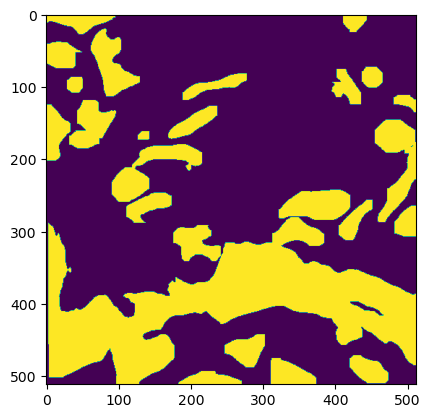

In [14]:
plt.imshow(np.any(masks, 0))